# Resitive Crack FFT Modeling
---

## Page Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Packages
import os
import sys
import copy
import time
import tabulate
import numpy as np
sys.path.append(os.path.join(os.path.abspath(""), ".."))

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [4]:
from app.models import Classifier
from app.utils import ImageWrapper 
from app.transforms import FFT, IFFT, CreateOnesMask, Butterworth
from app.filters import CreateKernel, Convolve, Canny, HOG
from app.imager import ImageLoader, DefectViewer, Show, Exposure
from app.custom import RemoveBusBars, Orient, HighlightFrontGrid

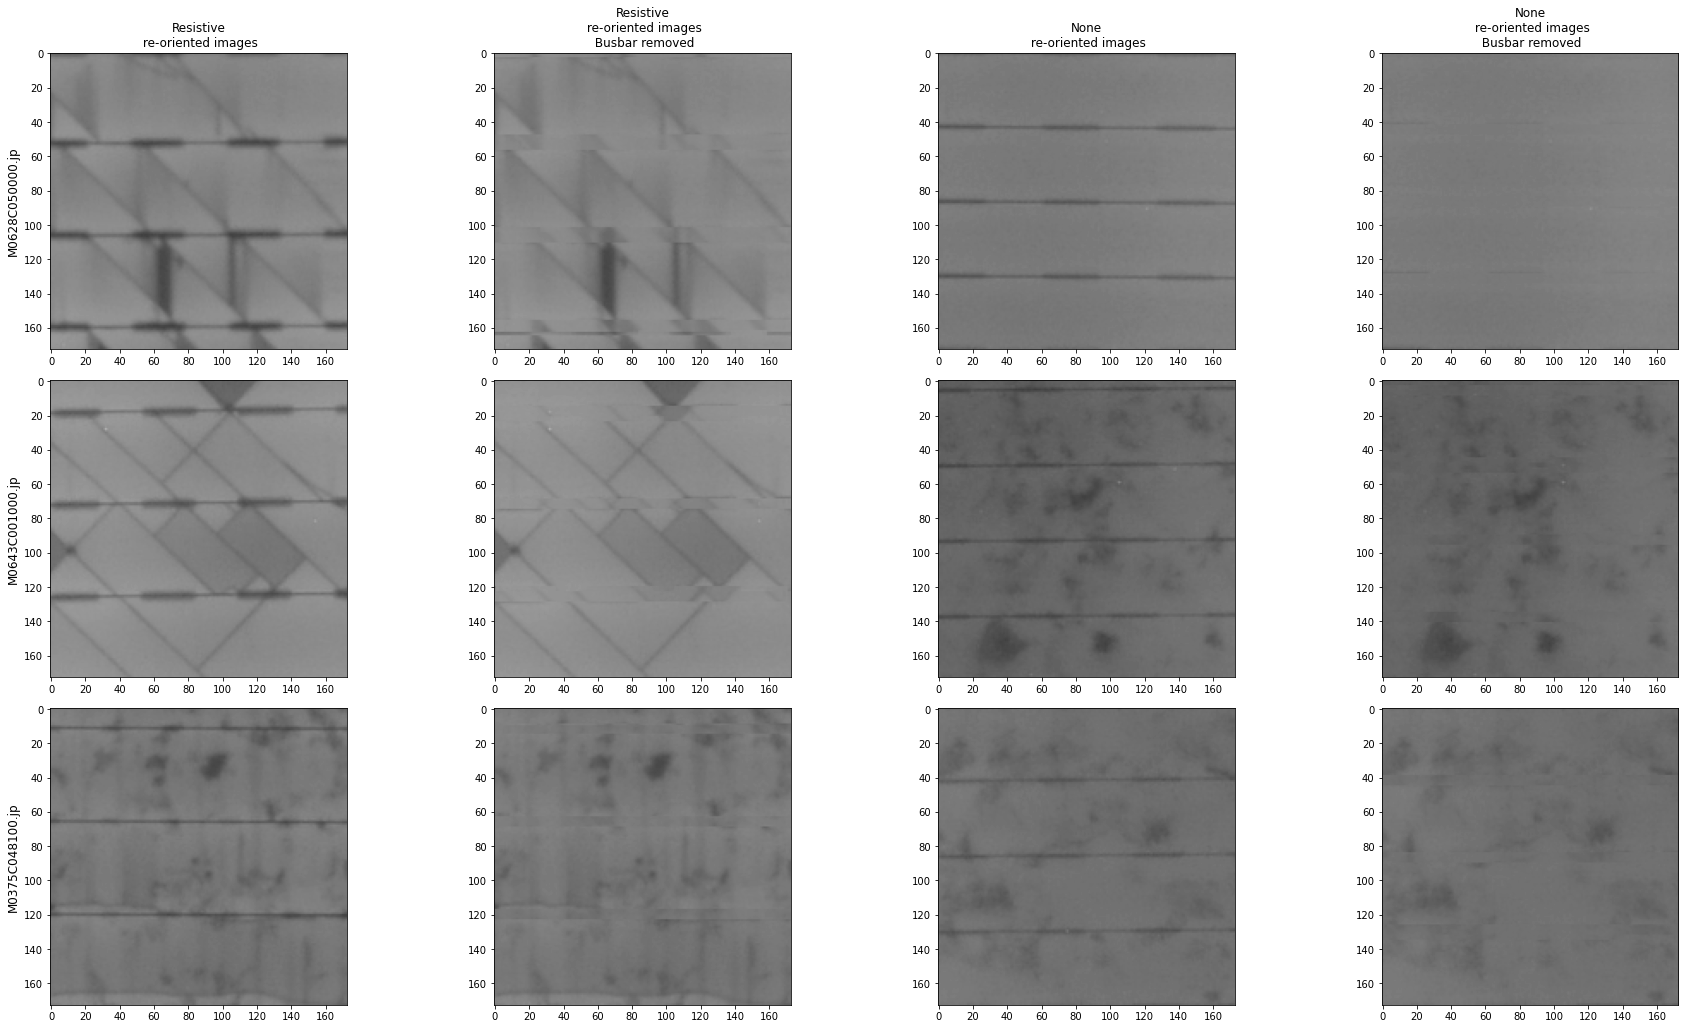

In [5]:
# Load 10 examples and name the category for it. Category is like a title for images
n_samples = 500
seed = 1234
defect = (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class='Resistive') << n_samples))
defect.category = 'Resistive'
clean = (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class='None') << n_samples))
clean.category = 'None'
all_else = (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class='Resistive', is_not=True) << n_samples))
all_else.category = 'all_else'

oriented_defect = Orient(num_jobs=20) << defect
oriented_clean = Orient(num_jobs=20) << clean
oriented_all_else = Orient(num_jobs=20) << all_else
nobus_defect = RemoveBusBars() << oriented_defect
nobus_clean = RemoveBusBars() << oriented_clean
nobus_all_else = RemoveBusBars() << oriented_all_else

# View both the defect and the clean class
# I am using a tuple in this case as defect and clean are ImageWrapper objects
# Show random 5 out of the 10 images. Using the seed will ensure the same 5 are shown everytime
_ = Show(num_images=3, seed=seed) << nobus_defect + nobus_clean

## FFT Transforms
---

In [6]:
import matplotlib.pyplot as plt
import numpy as np

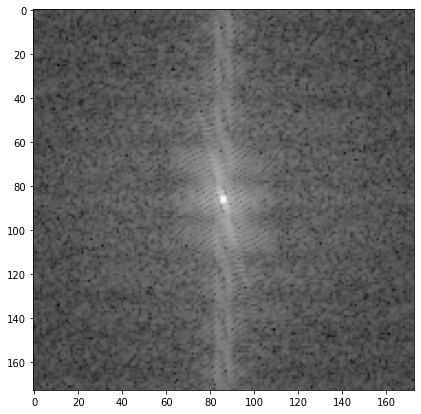

In [7]:
fft_images = FFT(dim=2) << nobus_defect
amplitued = ~(fft_images[1])
fig = plt.figure()
fig.set_size_inches(7,7)
plt.imshow(amplitued[0], cmap='gray', vmin=np.min(amplitued[0]), vmax=np.max(amplitued[0]))
plt.show()

In [ ]:
# _ = Show(do_show=True, num_images=10) << fft_images

In [ ]:
# defect_sigmoid = Exposure('sigmoid', inverse=True) << nobus_defect
# cm = CreateOnesMask(~nobus_defect[-1])
# # mask = cm.horizontal_from_center(left_width=10, right_width=10, height=3, val=0)
# mask = cm.vertical_from_center(top_height=100, bottom_height=1000, width=1000, val=1)
# # mask = cm.center_circle(radius=100)
# # _ = Show(do_show=True, num_images=10) << (IFFT(mask) << (Show(do_show=False, num_images=10) << (FFT(dim=2) << defect_sigmoid)))

# _ = Show(do_show=True, num_images=10) << (IFFT(mask) << (FFT(dim=2) << nobus_defect[-1]))

In [ ]:
images_ifft = (IFFT() << fft_images)
_ = Show(do_show=True, num_images=10) << images_ifft

In [ ]:
# Butterworh Lowpass Filter
def butterworth_low(f, D0, n):
    M,N = f.shape
    H = np.zeros((M,N), dtype=np.float32)

    for u in range(M):
        for v in range(N):
            D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
            H[u,v] = 1 / (1 + (D/D0)**(2*n))
    return H

# Butterworth highpass filter
def butterworth_high(f, D0, n):
    M,N = f.shape
    H = np.zeros((M,N), dtype=np.float32)

    for u in range(M):
        for v in range(N):
            D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
            H[u,v] = 1 / (1 + (D0/D)**(2*n))
    return H

# Butterworth Bandpass
def butterworth_band(f, D0_low, D0_high, n_low, n_high):
    high = butterworth_high(f, D0_high, n_high)
    low = butterworth_low(f, D0_low, n_low)
    band = low + high
    return band
    

In [ ]:
# x=(~defect)[3]
q = ~(nobus_defect)[1]
x = q[10]
fig = plt.figure()
fig.set_size_inches(7,7)
plt.imshow(x, cmap='gray')
plt.show()

In [ ]:
F = np.fft.fft2(x)
Fshift = np.fft.fftshift(F)

# mask = butterworth_low(Fshift, 3, 1)
# mask = butterworth_high(Fshift, 15, 1)
mask = butterworth_band(Fshift, 3, 15, 1, 1)

Gshift = np.multiply(mask, Fshift)

G = np.fft.ifftshift(Gshift)
f = np.abs(np.fft.ifft2(G))

fig.set_size_inches(7,7)
plt.imshow(f, cmap='gray')
plt.show()

##  Bring Into App Codebase
---

In [8]:
# btw = Butterworth((~(nobus_defect)[1]))
x = nobus_defect[-1]
btw = Butterworth(((~x)[0]))
btw.bandpass(3, 15, 1, 1)

array([[0.98578817, 0.9856255 , 0.98546106, ..., 0.98529476, 0.98546106,
        0.9856255 ],
       [0.9856255 , 0.9854591 , 0.98529077, ..., 0.9851205 , 0.98529077,
        0.9854591 ],
       [0.98546106, 0.98529077, 0.9851185 , ..., 0.9849442 , 0.9851185 ,
        0.98529077],
       ...,
       [0.98529476, 0.9851205 , 0.9849442 , ..., 0.9847658 , 0.9849442 ,
        0.9851205 ],
       [0.98546106, 0.98529077, 0.9851185 , ..., 0.9849442 , 0.9851185 ,
        0.98529077],
       [0.9856255 , 0.9854591 , 0.98529077, ..., 0.9851205 , 0.98529077,
        0.9854591 ]], dtype=float32)

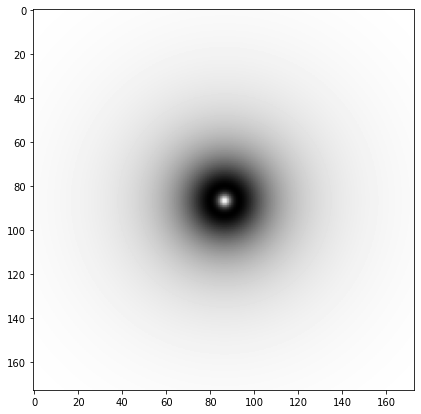

In [9]:
mask = btw.bandpass(3, 15, 1, 1)

fig = plt.figure()
fig.set_size_inches(7,7)
plt.imshow(mask, cmap='gray')
plt.show()

In [10]:
# images = Show(do_show=True) << (IFFT(mask)
f = FFT(dim=2) << nobus_defect
iff = IFFT(mask) << f 

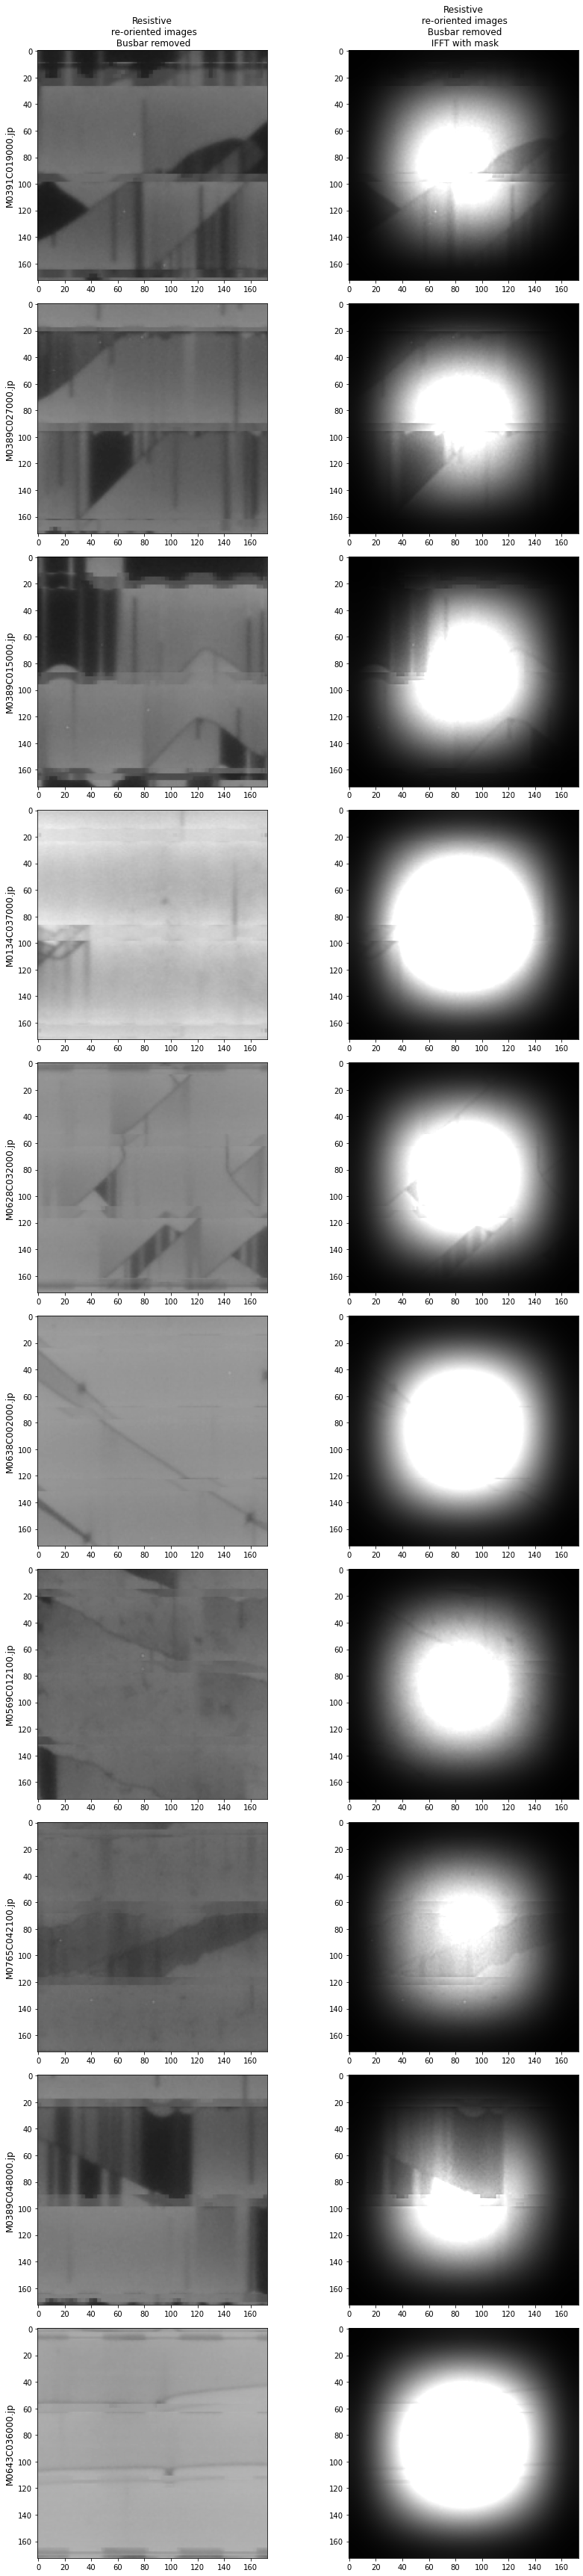

In [11]:
_ = Show(do_show=True, num_images=10) << iff

## Classifiers with Just Band Pass
---

In [ ]:
# nobus_all_else

In [12]:
%%time
# 1. Base model on raw data
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(nobus_defect[-1], nobus_clean[-1], LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.7064902852418354
          Pred 0    Pred 1
------  --------  --------
True 0        70        12
True 1        52        66
CPU times: user 2.77 s, sys: 235 ms, total: 3.01 s
Wall time: 671 ms


/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [13]:
%%time
# 1A. Base model on raw data (all else)
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(nobus_defect[-1], nobus_all_else[-1], LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.6505787515502274
          Pred 0    Pred 1
------  --------  --------
True 0        65        17
True 1        58        60
CPU times: user 2.74 s, sys: 187 ms, total: 2.92 s
Wall time: 640 ms


/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [14]:
%%time
# 2. HOG on RAW data
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100, 'num_jobs': 20}
cla = Classifier(nobus_defect[-1], nobus_clean[-1], LogisticRegression, HOG)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.7769739561802398
          Pred 0    Pred 1
------  --------  --------
True 0        76         6
True 1        44        74
CPU times: user 2.8 s, sys: 862 ms, total: 3.66 s
Wall time: 4.24 s


In [15]:
%%time
# 2A. HOG on RAW data (All Else)
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100, 'num_jobs': 20}
cla = Classifier(nobus_defect[-1], nobus_all_else[-1], LogisticRegression, HOG)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.7266432410086813
          Pred 0    Pred 1
------  --------  --------
True 0        74         8
True 1        53        65
CPU times: user 2.71 s, sys: 820 ms, total: 3.53 s
Wall time: 4.19 s


In [16]:
%%time
# 3. Base model on bandfilterd
mask = btw.bandpass(3, 15, 1, 1)
band_defect = IFFT(mask) << (FFT(dim=2, axis=(-2, -1)) << nobus_defect)
band_clean = IFFT(mask) << (FFT(dim=2, axis=(-2, -1)) << nobus_clean)
band_all_else = IFFT(mask) << (FFT(dim=2, axis=(-2, -1)) << nobus_all_else)

model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(band_defect[-1], band_clean[-1], LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.6800330715171559
          Pred 0    Pred 1
------  --------  --------
True 0        74         8
True 1        64        54
CPU times: user 7.93 s, sys: 1.08 s, total: 9.01 s
Wall time: 6.79 s


/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [17]:
%%time
# 3A. Base model on bandfilterd
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(band_defect[-1], band_all_else[-1], LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.6593633732947499
          Pred 0    Pred 1
------  --------  --------
True 0        72        10
True 1        66        52
CPU times: user 2.74 s, sys: 283 ms, total: 3.02 s
Wall time: 742 ms


/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [18]:
%%time
# 4. Base model on raw
band_defect = IFFT(mask) << (FFT(dim=2, axis=(-2, -1)) << defect)
band_clean = IFFT(mask) << (FFT(dim=2, axis=(-2, -1)) << clean)
band_call_else = IFFT(mask) << (FFT(dim=2, axis=(-2, -1)) << all_else)

model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(band_defect[-1], band_clean[-1], LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.6971889210417528
          Pred 0    Pred 1
------  --------  --------
True 0        65        17
True 1        47        71
CPU times: user 7.93 s, sys: 1.01 s, total: 8.94 s
Wall time: 6.72 s


/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [19]:
%%time
# 4. Base model on raw
band_defect = IFFT(mask) << (FFT(dim=2, axis=(-2, -1)) << defect)
band_clean = IFFT(mask) << (FFT(dim=2, axis=(-2, -1)) << clean)
band_all_else = IFFT(mask) << (FFT(dim=2, axis=(-2, -1)) << all_else)

model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(band_defect[-1], band_all_else[-1], LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.6516122364613477
          Pred 0    Pred 1
------  --------  --------
True 0        61        21
True 1        52        66
CPU times: user 7.9 s, sys: 1.26 s, total: 9.16 s
Wall time: 6.91 s


/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


## CNN
---

In [20]:
from app.models import ModelNN

lr = 0.0001
optimizer_params = {'name': 'sgd', 'lr': lr, 'nesterov': True, 'momentum': 0.9}
scheduler_params = {'lr_min': lr/100, 't_mul': 2}
model_params = {'num_output_classes': 2, 'dense_layers': (300, 300, 300), 'dense_activation': 'relu', 'pca_dims': 300, 'dropout': 0.2}

model = ModelNN(defect, clean, model_params, optimizer_params, scheduler_params, model_type='dnn')
score = model.fit(num_epochs=20)

print(score)

# scores.append(score)
# legends.append('DNN on oriented images')

Epoch 0 train loss 0.7865893483161926 val loss 0.6354077288082668 lr [9.943826136452675e-05]
Epoch 1 train loss 0.6670268774032593 val loss 0.5074458164828164 lr [9.767247740510234e-05]
Epoch 2 train loss 0.6024334752559661 val loss 0.45819377473422457 lr [9.474515049548756e-05]
Epoch 3 train loss 0.5386675715446472 val loss 0.4342783348900931 lr [9.072836113943815e-05]
Epoch 4 train loss 0.5236923694610596 val loss 0.41928171260016306 lr [8.572101602185964e-05]
Epoch 5 train loss 0.49709881663322447 val loss 0.40037958111081806 lr [7.984641259797244e-05]
Epoch 6 train loss 0.4896860980987549 val loss 0.3936951458454132 lr [7.324920310076365e-05]
Epoch 7 train loss 0.47198076725006105 val loss 0.386896801846368 lr [6.609183272293759e-05]
Epoch 8 train loss 0.44851566195487974 val loss 0.37933712346213205 lr [5.855053967714674e-05]
Epoch 9 train loss 0.448396692276001 val loss 0.3763776123523712 lr [5.081101562629518e-05]
Epoch 10 train loss 0.44884031772613525 val loss 0.37115521090371

In [21]:
lr = 0.0001
optimizer_params = {'name': 'sgd', 'lr': lr, 'nesterov': True, 'momentum': 0.9}
scheduler_params = {'lr_min': lr/100, 't_mul': 2}
model_params = {'num_output_classes': 2, 'dense_layers': (300, 300, 300), 'dense_activation': 'relu', 'pca_dims': 300, 'dropout': 0.2}

model = ModelNN(defect, all_else, model_params, optimizer_params, scheduler_params, model_type='dnn')
score = model.fit(num_epochs=20)

print(score)

Epoch 0 train loss 0.7986549949645996 val loss 0.677675894328526 lr [9.943826136452675e-05]
Epoch 1 train loss 0.7217952799797058 val loss 0.6283868295805795 lr [9.767247740510234e-05]
Epoch 2 train loss 0.6773730635643005 val loss 0.605787992477417 lr [9.474515049548756e-05]
Epoch 3 train loss 0.6454840910434723 val loss 0.5888522820813316 lr [9.072836113943815e-05]
Epoch 4 train loss 0.6263760232925415 val loss 0.5839580808367048 lr [8.572101602185964e-05]
Epoch 5 train loss 0.5920614159107208 val loss 0.5800379983016423 lr [7.984641259797244e-05]
Epoch 6 train loss 0.5786970508098602 val loss 0.572260286126818 lr [7.324920310076365e-05]
Epoch 7 train loss 0.5739307606220245 val loss 0.5626065347875867 lr [6.609183272293759e-05]
Epoch 8 train loss 0.575236302614212 val loss 0.5575554200581142 lr [5.855053967714674e-05]
Epoch 9 train loss 0.549950053691864 val loss 0.5573886547769819 lr [5.081101562629518e-05]
Epoch 10 train loss 0.5577797794342041 val loss 0.5509638105119977 lr [4.30

In [22]:
from app.models import ModelNN

lr = 0.0001
optimizer_params = {'name': 'sgd', 'lr': lr, 'nesterov': True, 'momentum': 0.9}
scheduler_params = {'lr_min': lr/100, 't_mul': 2}
model_params = {'num_output_classes': 2, 'dense_layers': (300, 300, 300), 'dense_activation': 'relu', 'pca_dims': 300, 'dropout': 0.2}

model = ModelNN(band_defect[-1], band_clean[-1], model_params, optimizer_params, scheduler_params, model_type='dnn')
score = model.fit(num_epochs=20)

print(score)

Epoch 0 train loss 0.735125138759613 val loss 0.6585041540009635 lr [9.943826136452675e-05]
Epoch 1 train loss 0.6204286408424378 val loss 0.6063435333115714 lr [9.767247740510234e-05]
Epoch 2 train loss 0.5915606963634491 val loss 0.5914507167679923 lr [9.474515049548756e-05]
Epoch 3 train loss 0.5833789920806884 val loss 0.5675864049366542 lr [9.072836113943815e-05]
Epoch 4 train loss 0.546862187385559 val loss 0.5468440439019885 lr [8.572101602185964e-05]
Epoch 5 train loss 0.5242418146133423 val loss 0.5510797458035606 lr [7.984641259797244e-05]
Epoch 6 train loss 0.5140837109088898 val loss 0.538295716047287 lr [7.324920310076365e-05]
Epoch 7 train loss 0.4925834834575653 val loss 0.5393608169896262 lr [6.609183272293759e-05]
Epoch 8 train loss 0.5040067791938782 val loss 0.5383471378258297 lr [5.855053967714674e-05]
Epoch 9 train loss 0.4642607319355011 val loss 0.540145069360733 lr [5.081101562629518e-05]
Epoch 10 train loss 0.4646311986446381 val loss 0.5386692583560944 lr [4.3

In [23]:
from app.models import ModelNN

lr = 0.0001
optimizer_params = {'name': 'sgd', 'lr': lr, 'nesterov': True, 'momentum': 0.9}
scheduler_params = {'lr_min': lr/100, 't_mul': 2}
model_params = {'num_output_classes': 2, 'dense_layers': (300, 300, 300), 'dense_activation': 'relu', 'pca_dims': 300, 'dropout': 0.2}

model = ModelNN(band_defect[-1], band_call_else[-1], model_params, optimizer_params, scheduler_params, model_type='dnn')
score = model.fit(num_epochs=20)

print(score)

Epoch 0 train loss 0.8178664040565491 val loss 0.7157844815935407 lr [9.943826136452675e-05]
Epoch 1 train loss 0.7133938574790955 val loss 0.6940043994358608 lr [9.767247740510234e-05]
Epoch 2 train loss 0.6695699834823609 val loss 0.6705203056335449 lr [9.474515049548756e-05]
Epoch 3 train loss 0.6491976726055145 val loss 0.6543683920587812 lr [9.072836113943815e-05]
Epoch 4 train loss 0.6342581248283387 val loss 0.6421981964792524 lr [8.572101602185964e-05]
Epoch 5 train loss 0.6055299746990204 val loss 0.6480744821684701 lr [7.984641259797244e-05]
Epoch 6 train loss 0.6036799371242523 val loss 0.6438559293746948 lr [7.324920310076365e-05]
Epoch 7 train loss 0.6115850925445556 val loss 0.6348190818514142 lr [6.609183272293759e-05]
Epoch 8 train loss 0.5788815987110137 val loss 0.6224536895751953 lr [5.855053967714674e-05]
Epoch 9 train loss 0.561940826177597 val loss 0.6203486749104091 lr [5.081101562629518e-05]
Epoch 10 train loss 0.5745815372467041 val loss 0.6197234903063092 lr [

In [32]:
!conda install -c conda-forge tpot xgboost dask dask-ml scikit-mdr skrebate -y

Solving environment: \ 
  - anaconda/linux-64::ca-certificates-2022.3.29-h06a4308_1, anaconda/linux-64::certifi-2021.10.8-py39h06a4308_2, anaconda/linux-64::openssl-1.1.1n-h7f8727e_0
  - anaconda/linux-64::ca-certificates-2022.3.29-h06a4308_1, anaconda/linux-64::certifi-2021.10.8-py39h06a4308_2, defaults/linux-64::openssl-1.1.1n-h7f8727e_0
  - anaconda/linux-64::certifi-2021.10.8-py39h06a4308_2, anaconda/linux-64::openssl-1.1.1n-h7f8727e_0, defaults/linux-64::ca-certificates-2022.3.29-h06a4308_1
  - anaconda/linux-64::certifi-2021.10.8-py39h06a4308_2, defaults/linux-64::ca-certificates-2022.3.29-h06a4308_1, defaults/linux-64::openssl-1.1.1n-h7f8727e_0
  - anaconda/linux-64::openssl-1.1.1n-h7f8727e_0, defaults/linux-64::ca-certificates-2022.3.29-h06a4308_1, defaults/linux-64::certifi-2021.10.8-py39h06a4308_2
  - defaults/linux-64::ca-certificates-2022.3.29-h06a4308_1, defaults/linux-64::certifi-2021.10.8-py39h06a4308_2, defaults/linux-64::openssl-1.1.1n-h7f8727e_0
  - anaconda/linux-64:

In [24]:
from sklearn.model_selection import train_test_split
import sklearn.metrics
import timeit
# make the data set
# defect, clean
c_len = len((~clean)[-1])
d_len= len((~defect)[-1])

X = np.concatenate((((~clean)[-1]),((~defect)[-1])), axis=0)
c_val = np.full((1, c_len), 0)
d_val = np.full((1, d_len), 1)
y = np.concatenate((c_val, d_val), axis=1)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [25]:
# from tpot import TPOTClassifier
# tpot = TPOTClassifier(verbosity=3, 
#  scoring='accuracy',
#  random_state=32,
#  periodic_checkpoint_folder='tpot_results.txt',
#  n_jobs=-1,
#  generations=10,
#  population_size=5,
#  early_stop=5)

In [26]:
# times = []
# winning_pipes=[]
# scores=[]

# for x in range(3):
#     start_time = timeit.default_timer()
#     tpot.fit(X_train, y_train)
#     elapsed = timeit.default_timer() - start_time
#     times.append(elapsed)
#     winning_pipes.append(tpot.fitted_pipeline_)
#     scores.append(tpot.score(X_test, y_test))
#     tpot.export('tpot_mnist_pipeline.py')
    
    
# times = [time/60 for time in times]
# print('Times:', times)
# print('Scores:', scores)   
# print('Winning pipelines:', winning_pipes)

In [ ]:
# tpot = TPOTClassifier(verbosity=3, 
#  scoring='accuracy',
#  random_state=32,
#  periodic_checkpoint_folder='tpot_results.txt',
#  config_dict="TPOT cuML",
#  n_jobs=1,
#  generations=10,
#  population_size=5,
#  early_stop=5)


# times = []
# winning_pipes=[]
# scores=[]

# for x in range(3):
#     start_time = timeit.default_timer()
#     tpot.fit(X_train, y_train)
#     elapsed = timeit.default_timer() - start_time
#     times.append(elapsed)
#     winning_pipes.append(tpot.fitted_pipeline_)
#     scores.append(tpot.score(X_test, y_test))
#     tpot.export('tpot_mnist_pipeline.py')
    
    
# times = [time/60 for time in times]
# print('Times:', times)
# print('Scores:', scores)   
# print('Winning pipelines:', winning_pipes)

In [39]:
from dask.distributed import Client
client = Client(n_workers=4, threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 31.15 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33751,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 31.15 GiB
Comm: tcp://127.0.0.1:36913,Total threads: 1
Dashboard: http://127.0.0.1:41679/status,Memory: 7.79 GiB
Nanny: tcp://127.0.0.1:41049,


In [43]:
client.shutdown()

/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [45]:
from tpot import TPOTClassifier

In [34]:
# tpot = TPOTClassifier(verbosity=2, 
#  scoring='accuracy',
#  random_state=32,
#  periodic_checkpoint_folder='tpot_results.txt',
#  n_jobs=-1,
#  generations=100,
#  population_size=100,
#  use_dask=True,
#  early_stop=5)

# times = []
# winning_pipes=[]
# scores=[]

# for x in range(3):
#     start_time = timeit.default_timer()
#     tpot.fit(X_train, y_train)
#     elapsed = timeit.default_timer() - start_time
#     times.append(elapsed)
#     winning_pipes.append(tpot.fitted_pipeline_)
#     scores.append(tpot.score(X_test, y_test))
#     tpot.export('tpot_mnist_pipeline.py')
    
    
# times = [time/60 for time in times]
# print('Times:', times)
# print('Scores:', scores)   
# print('Winning pipelines:', winning_pipes)

NameError: name 'TPOTClassifier' is not defined

In [ ]:
# tpot.export('tpot.py')

## Tpot Raw Defects vs All Else
---

In [36]:
# Raw All Else

# Get Images
c = (~defect)
d = (~all_else)

# Flatten Immages (3 Dim array to 2 Dim Array)
c_flat = []
d_flat = []

for i in c:
    c_flat.append(i.flatten())

for i in d:
    d_flat.append(i.flatten())

X = np.concatenate((np.array(c_flat), np.array(d_flat)), axis=0)
c_val = np.full((1, len(c_flat)), 0)
d_val = np.full((1, len(d_flat)), 1)
y = np.concatenate((c_val, d_val), axis=1)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [46]:
tpot = TPOTClassifier(verbosity=2, 
 scoring='accuracy',
 random_state=32,
 periodic_checkpoint_folder='tpot_results.txt',
 n_jobs=-1,
 generations=10,
 population_size=10,
#  use_dask=True,
 early_stop=5)

times = []
winning_pipes=[]
scores=[]

for x in range(3):
    start_time = timeit.default_timer()
    tpot.fit(X_train, y_train)
    elapsed = timeit.default_timer() - start_time
    times.append(elapsed)
    winning_pipes.append(tpot.fitted_pipeline_)
    scores.append(tpot.score(X_test, y_test))
    
    
times = [time/60 for time in times]
print('Times:', times)
print('Scores:', scores)   
print('Winning pipelines:', winning_pipes)

Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.764

Generation 2 - Current best internal CV score: 0.764

Generation 3 - Current best internal CV score: 0.764

Generation 4 - Current best internal CV score: 0.764

Generation 5 - Current best internal CV score: 0.764

Generation 6 - Current best internal CV score: 0.764

The optimized pipeline was not improved after evaluating 5 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.1, max_depth=3, min_child_weight=8, n_estimators=100, n_jobs=1, subsample=0.8, verbosity=0)


Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.764

Generation 2 - Current best internal CV score: 0.764

Generation 3 - Current best internal CV score: 0.764

Generation 4 - Current best internal CV score: 0.764

Generation 5 - Current best internal CV score: 0.764

Generation 6 - Current best internal CV score: 0.764

The optimized pipeline was not improved after evaluating 5 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.1, max_depth=3, min_child_weight=8, n_estimators=100, n_jobs=1, subsample=0.8, verbosity=0)


Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]



TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.


RuntimeError: A pipeline has not yet been optimized. Please call fit() first.

In [ ]:
# 0.764 Best pipeline: XGBClassifier(input_matrix, learning_rate=0.1, max_depth=3, min_child_weight=8, n_estimators=100, n_jobs=1, subsample=0.8, verbosity=0)

## TPOT Band Defect Vs All Else
---

In [48]:
# Get Images
c = (~band_defect[-1])
d = (~band_all_else[-1])

# Flatten Immages (3 Dim array to 2 Dim Array)
c_flat = []
d_flat = []

for i in c:
    c_flat.append(i.flatten())

for i in d:
    d_flat.append(i.flatten())

X = np.concatenate((np.array(c_flat), np.array(d_flat)), axis=0)
c_val = np.full((1, len(c_flat)), 0)
d_val = np.full((1, len(d_flat)), 1)
y = np.concatenate((c_val, d_val), axis=1)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [51]:
# # band
# c_len = len(~band_defect[-1])
# d_len= len(~band_all_else[-1])

# X = np.concatenate(((~band_all_else[-1]),(~band_defect[-1])), axis=0)
# c_val = np.full((1, c_len), 0)
# d_val = np.full((1, d_len), 1)
# y = np.concatenate((c_val, d_val), axis=1)[0]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

tpot = TPOTClassifier(verbosity=2, 
 scoring='accuracy',
 random_state=32,
 periodic_checkpoint_folder='tpot_results.txt',
 n_jobs=-1,
 generations=10,
 population_size=10,
#  use_dask=True,
 early_stop=5)

times = []
winning_pipes=[]
scores=[]


start_time = timeit.default_timer()
tpot.fit(X_train, y_train)
elapsed = timeit.default_timer() - start_time
times.append(elapsed)
winning_pipes.append(tpot.fitted_pipeline_)
scores.append(tpot.score(X_test, y_test))
tpot.export('tpot_mnist_pipeline.py')
    
    
times = [time/60 for time in times]
print('Times:', times)
print('Scores:', scores)   
print('Winning pipelines:', winning_pipes)

# Scores: [0.792]
# Winning pipelines: [Pipeline(steps=[('extratreesclassifier',
#                  ExtraTreesClassifier(max_features=0.1, min_samples_split=8,
#                                       random_state=32))])]

Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.688

Generation 2 - Current best internal CV score: 0.688

Generation 3 - Current best internal CV score: 0.688

Generation 4 - Current best internal CV score: 0.6933333333333331

Generation 5 - Current best internal CV score: 0.74

Generation 6 - Current best internal CV score: 0.74

Generation 7 - Current best internal CV score: 0.7426666666666667

Generation 8 - Current best internal CV score: 0.752

Generation 9 - Current best internal CV score: 0.752

Generation 10 - Current best internal CV score: 0.752

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.01, max_depth=6, max_features=0.05, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.9000000000000001)
Times: [62.07319232088336]
Scores: [0.784]
Winning pipelines: [Pipeline(steps=[('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=6,
                                            max_fe

In [52]:
# Get Images
c = (~band_defect[-1])
d = (~band_clean[-1])

# Flatten Immages (3 Dim array to 2 Dim Array)
c_flat = []
d_flat = []

for i in c:
    c_flat.append(i.flatten())

for i in d:
    d_flat.append(i.flatten())

X = np.concatenate((np.array(c_flat), np.array(d_flat)), axis=0)
c_val = np.full((1, len(c_flat)), 0)
d_val = np.full((1, len(d_flat)), 1)
y = np.concatenate((c_val, d_val), axis=1)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# # Raw All Else
# c_len = len((~band_defect)[-1])
# d_len= len((~band_clean)[-1])

# X = np.concatenate((((~clean)[-1]),((~defect)[-1])), axis=0)
# c_val = np.full((1, c_len), 0)
# d_val = np.full((1, d_len), 1)
# y = np.concatenate((c_val, d_val), axis=1)[0]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

tpot = TPOTClassifier(verbosity=2, 
 scoring='accuracy',
 random_state=32,
 periodic_checkpoint_folder='tpot_results.txt',
 n_jobs=-1,
 generations=10,
 population_size=10,
 use_dask=True,
 early_stop=5)

times = []
winning_pipes=[]
scores=[]

for x in range(3):
    start_time = timeit.default_timer()
    tpot.fit(X_train, y_train)
    elapsed = timeit.default_timer() - start_time
    times.append(elapsed)
    winning_pipes.append(tpot.fitted_pipeline_)
    scores.append(tpot.score(X_test, y_test))
    tpot.export('tpot_mnist_pipeline.py')
    
    
times = [time/60 for time in times]
print('Times:', times)
print('Scores:', scores)   
print('Winning pipelines:', winning_pipes)

Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]

## End Of Work
---

Best Model: 
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(nobus_defect[-1], nobus_clean[-1], LogisticRegression, None)
score = cla.fit(**model_params)

Second Best Model:
!-- # Scores: [0.792]
 Winning pipelines: [Pipeline(steps=[('extratreesclassifier',
                  ExtraTreesClassifier(max_features=0.1, min_samples_split=8,
                                       random_state=32))])] -->

Third Best
Winning pipelines: [Pipeline(steps=[('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=6,
                                            max_features=0.05,
                                            min_samples_leaf=2, random_state=32,
                                            subsample=0.9000000000000001))])]